## Audio -> Spectrogram -> CNN 

#### Classification
##### Classify each individual -> is individual x / is not individual x

Resources: 
- https://www.tensorflow.org/tutorials/audio/simple_audio
- https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab
- https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn
- https://towardsdatascience.com/custom-audio-classification-with-tensorflow-af8c16c38689https://towardsdatascience.com/custom-audio-classification-with-tensorflow-af8c16c38689

In [1]:
#Import libraries
import os
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import tensorflow as tf
import tensorflow_io as tfio #collection of file systems/file formats that aren't available in TensorFlow's built-in support.

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

import librosa
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

#### Load/Extract Data

In [2]:
# Set paths to input and output data
#INPUT_DIR = os.path.abspath("HumpbackAudioSegments")
#OUTPUT_DIR = os.path.abspath('spectrograms')

#returns the list of all files and directories in the specified path. The return type of this method is list.
# Print names of 10 WAV files from the input path
#song_list = os.listdir(INPUT_DIR)
#for i in song_list:
#    print(each)
#signal_wave = wave.open(os.path.join(INPUT_DIR, i), 'r')
#print(signal_wave)

#song1 = song_list[0]
#song1

In [2]:
#setup data directory path 
dataset_path = 'HumpbackAudioSegments'
data_dir = pathlib.Path(dataset_path)

In [3]:
#Determine Sampling rate
# Load audio file
audio_data, sr = librosa.load(data_dir/'NorthPacific/Cross_clip1.wav', sr=None)

# sr contains the sampling rate of the audio file
print(f"Sampling rate: {sr}")

Sampling rate: 10000


In [4]:
#Determine Sampling rate
# Load audio file
audio_data, sr = librosa.load(data_dir/'SouthPacific/garlandclip1.wav', sr=None)

# sr contains the sampling rate of the audio file
print(f"Sampling rate: {sr}")

Sampling rate: 24000


In [5]:
#Display audio clip
from IPython.display import Audio
Audio(data=audio_data, rate=sr, autoplay=True)

In [6]:
#Determine Sampling rate
# Load audio file
audio_data, sr = librosa.load(data_dir/'NorthPacific/Kauai1994_0852_clip1.wav', sr=None)

# sr contains the sampling rate of the audio file
print(f"Sampling rate: {sr}")

Sampling rate: 4000


In [7]:
#Display audio clip
from IPython.display import Audio
Audio(data=audio_data, rate=sr, autoplay=True)

In [8]:
labels = np.array(tf.io.gfile.listdir(str(data_dir)))
labels = labels[(labels != 'README.md') & (labels != '.DS_Store')]
print('Labels:', labels)

Labels: ['NorthPacific' 'SouthPacific']


#### Train/Val Dataset Split

- Audio clips are 30 seconds or less, at 30kHz (?)
- (batch, sample, channels)
- 'output_sequence_length' = length of input spectrogram. typically shorter than original audio signal.
    -  use a sliding window to split your audio clips into smaller chunks, and then set the output_sequence_length to the length of these smaller chunks. 
    - Ex: split 30-second audio clip into 3-second chunks, and set output_sequence_length to the number of samples in a 3-second chunk at sampling rate of 24000 Hz, which would be 3 * 24000 = 72000 samples.
- 'sampling rate' = the number of samples per second in an audio signal. 

In [9]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=72000, #description above
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 94 files belonging to 2 classes.
Using 76 files for training.
Using 18 files for validation.

label names: ['NorthPacific' 'SouthPacific']


- The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels).

In [10]:
train_ds.element_spec

(TensorSpec(shape=(None, 72000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

#### Drop extra channel/axis

- use tf.squeeze to drop extra axis (channel)

In [11]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [12]:
train_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 72000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### Build Test Set from Val
- use Dataset.shard to split the validation set into two halves

In [13]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

#### Visualize

In [14]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 72000)
(64,)


In [15]:
example_audio

<tf.Tensor: shape=(64, 72000), dtype=float32, numpy=
array([[ 0.01031494,  0.01025391,  0.00979614, ...,  0.01052856,
         0.01077271,  0.01071167],
       [ 0.01226807,  0.01254272,  0.01217651, ...,  0.01089478,
         0.01199341,  0.01266479],
       [ 0.00137329, -0.00393677,  0.02389526, ...,  0.02920532,
         0.04367065,  0.0291748 ],
       ...,
       [ 0.00964355,  0.01000977,  0.01004028, ...,  0.01055908,
         0.01040649,  0.01028442],
       [ 0.01043701,  0.01046753,  0.01043701, ...,  0.01080322,
         0.0105896 ,  0.01101685],
       [ 0.01489258,  0.01004028,  0.01156616, ...,  0.0111084 ,
         0.01098633,  0.01098633]], dtype=float32)>

In [18]:
label_names

array(['NorthPacific', 'SouthPacific'], dtype='<U12')

##### Audio Examples
- 'waveform' is a Tensor that contains the audio data in a time-domain representation. It has shape (samples, channels), where samples is the number of audio samples and channels is the number of audio channels 

In [19]:
# 'rate' = sampling rate of audio in Hz, the largest sampling rate = 24000
for i in range(5):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    print('Audio:', label)
    display.display(display.Audio(waveform, rate=24000))

Audio: NorthPacific


Audio: NorthPacific


Audio: NorthPacific


Audio: SouthPacific


Audio: NorthPacific


##### Waveform Examples

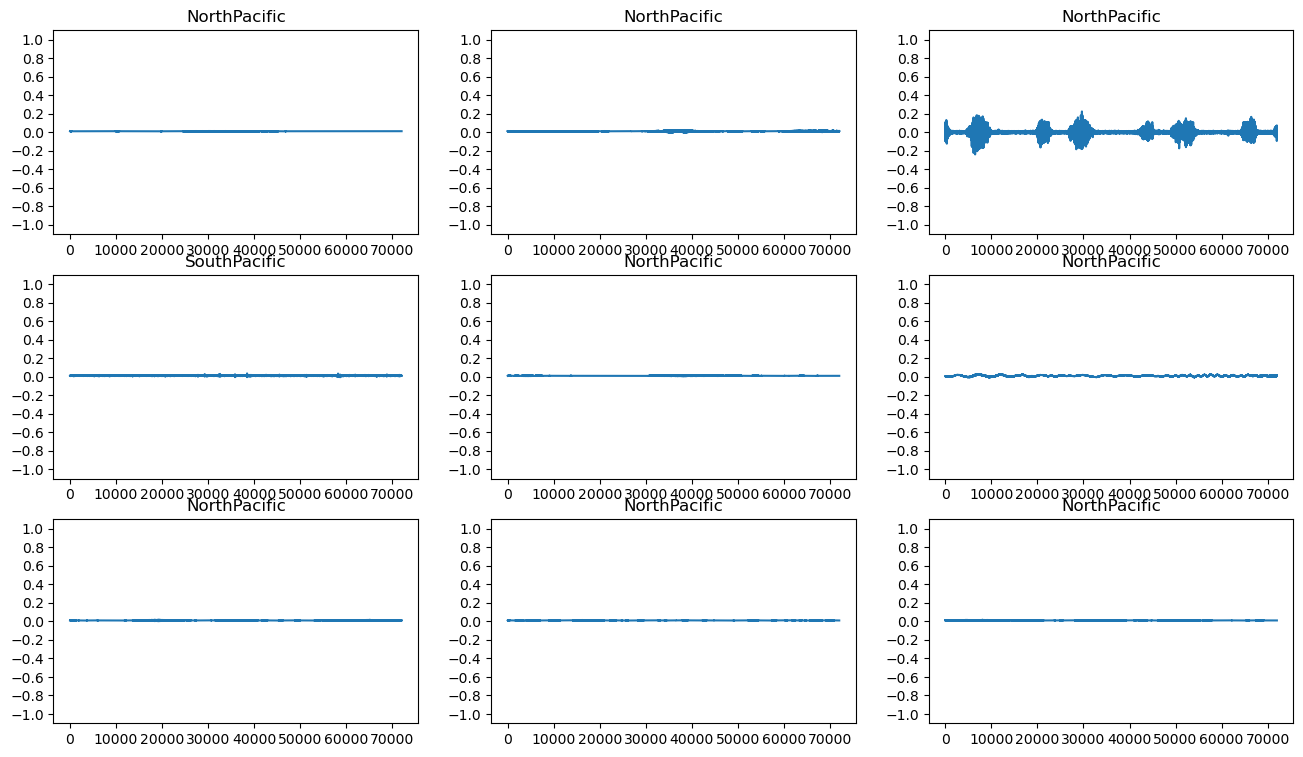

In [20]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

#### Build Spectrograms - short-time Fourier  
- The STFT requires the input tensor to have a shape of [batch_size, samples], where samples is the number of samples in the waveform.
- frame length = 512
- step = 256

In [21]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=512, frame_step=256)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [22]:
print('Waveform shape:', waveform.shape)
spectrogram = get_spectrogram(waveform)
print('Spectrogram shape:', spectrogram.shape)

Waveform shape: (72000,)
Spectrogram shape: (280, 257, 1)


#### Visualize

In [23]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

##### Spectrogram and Waveform

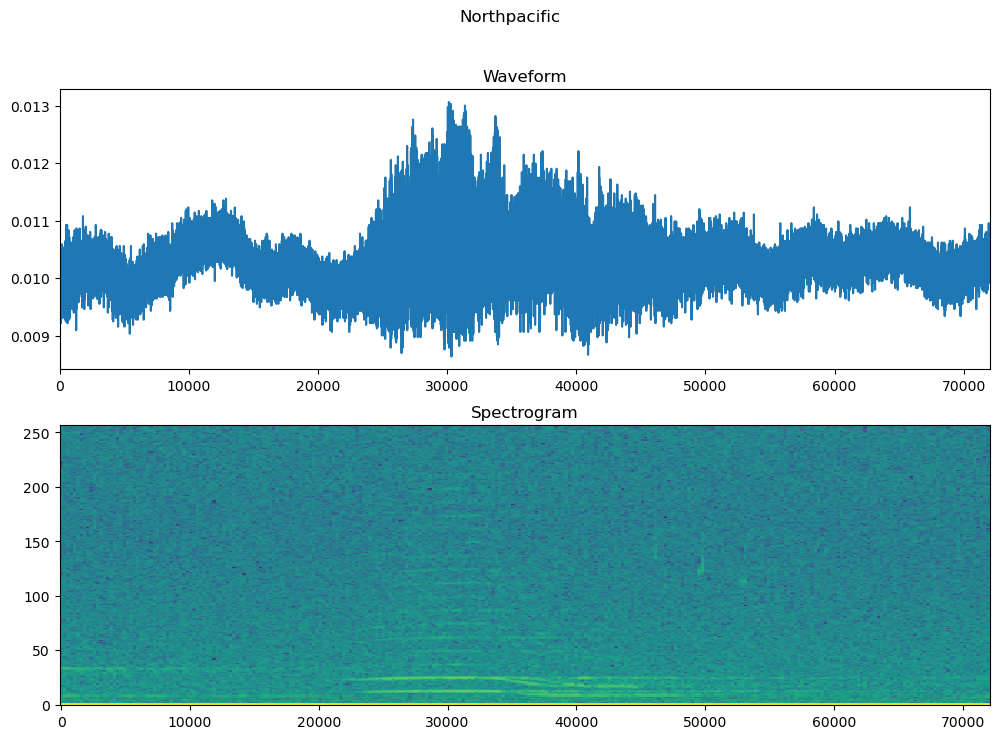

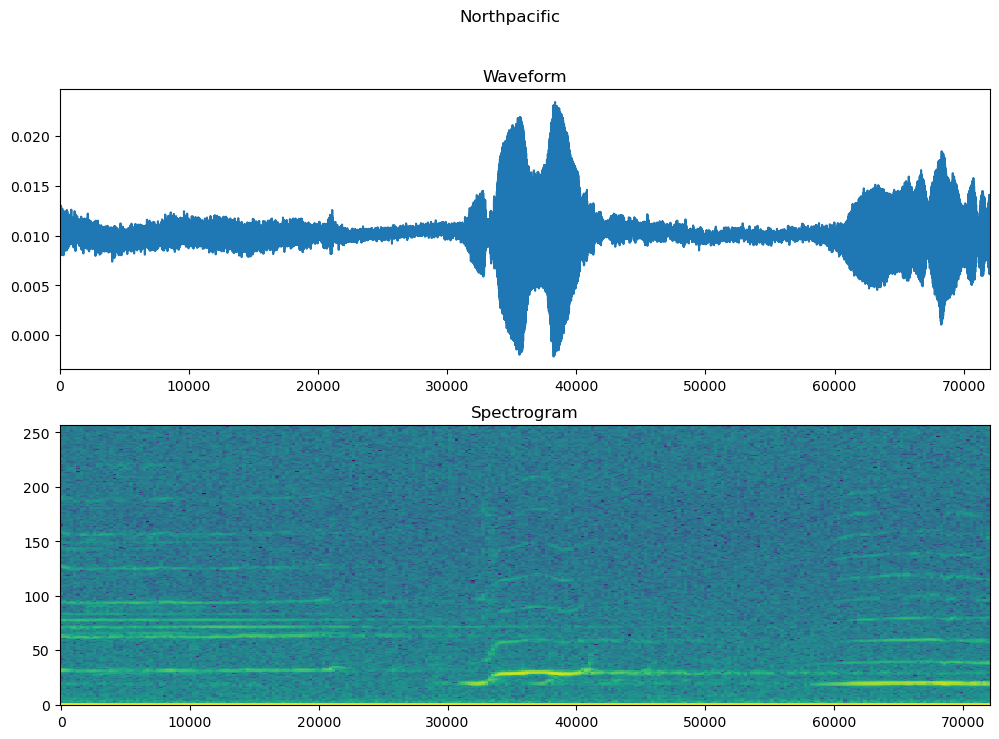

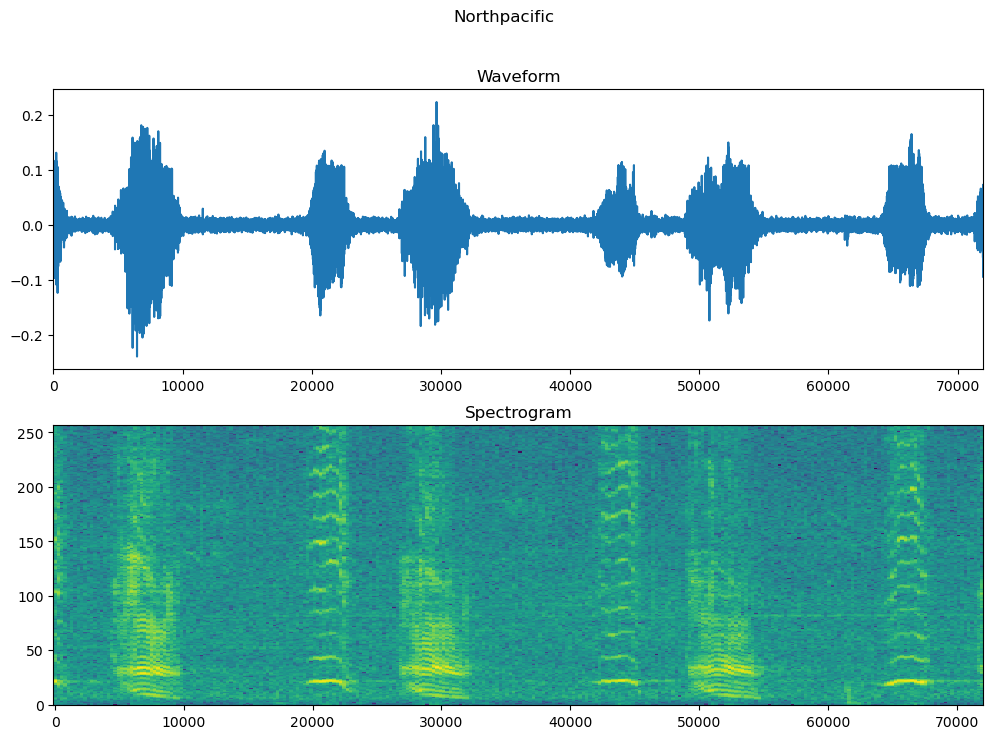

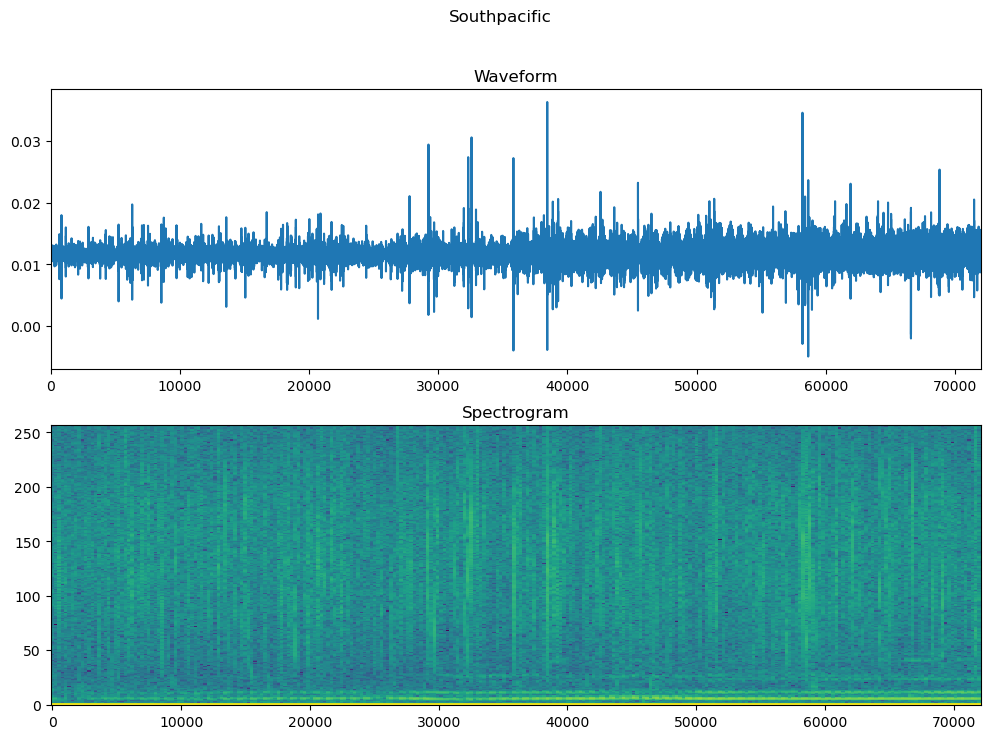

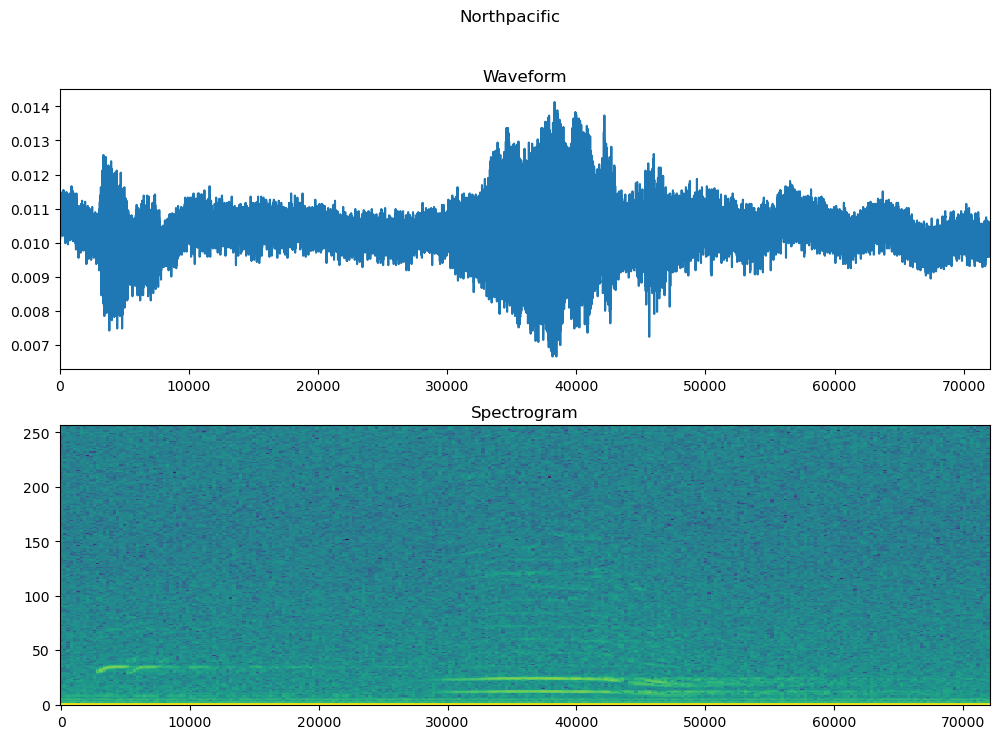

In [24]:
for i in range(5):    
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    
    fig, axes = plt.subplots(2, figsize=(12, 8))
    timescale = np.arange(waveform.shape[0])
    axes[0].plot(timescale, waveform.numpy())
    axes[0].set_title('Waveform')
    axes[0].set_xlim([0, 72000]) #maximum value of the audio signal's frequency domain

    plot_spectrogram(spectrogram.numpy(), axes[1])
    axes[1].set_title('Spectrogram')
    plt.suptitle(label.title())
    plt.show()

#### Build Spectrogram Dataset

In [25]:
def make_spec_ds(ds):  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [27]:
train_spectrogram_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 280, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### Visualize

In [28]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds:
    break

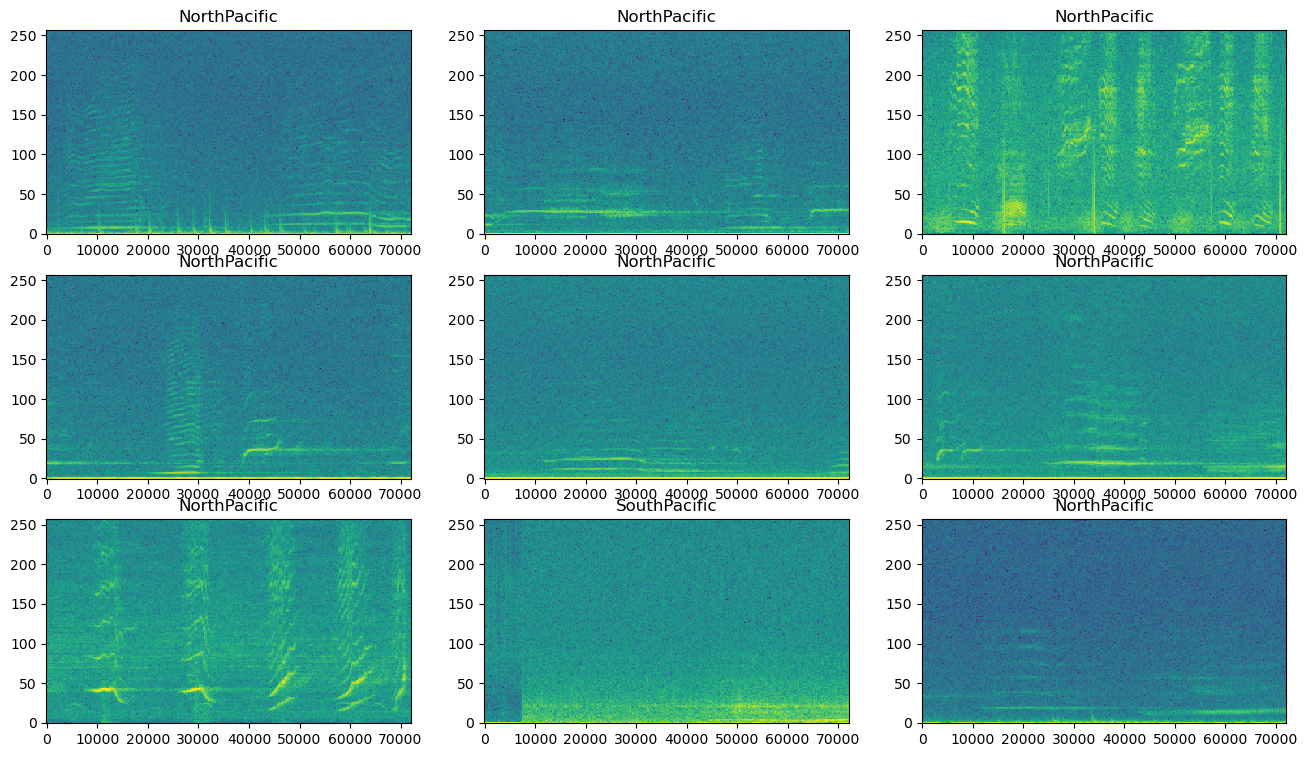

In [29]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

#### Build & Train CNN Model
- Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model

In [30]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [31]:
train_spectrogram_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 280, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

- tf.keras.Sequential
    - tf.keras.layers.Resizing: to downsample the input to enable the model to train faster.
    - tf.keras.layers.Normalization: to normalize each pixel in the image based on its mean and standard deviation.
        - use 'adapt' method on training data first, to compute mean and standard deviation

In [32]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (280, 257, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

#### Compile Model

In [33]:
#Compile with Adam
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

#### Fit Model

In [36]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
2/2 [==============================] - 0s 82ms/step - loss: 0.0909 - accuracy: 0.9737
Epoch 2/20
2/2 [==============================] - 0s 81ms/step - loss: 0.0682 - accuracy: 0.9737
Epoch 3/20
2/2 [==============================] - 0s 79ms/step - loss: 0.0762 - accuracy: 0.9605
Epoch 4/20
2/2 [==============================] - 0s 79ms/step - loss: 0.0721 - accuracy: 0.9737
Epoch 5/20
2/2 [==============================] - 0s 79ms/step - loss: 0.0535 - accuracy: 0.9737
Epoch 6/20
2/2 [==============================] - 0s 82ms/step - loss: 0.0582 - accuracy: 0.9737
Epoch 7/20
2/2 [==============================] - 0s 82ms/step - loss: 0.0541 - accuracy: 0.9737
Epoch 8/20
2/2 [==============================] - 0s 81ms/step - loss: 0.0639 - accuracy: 0.9737
Epoch 9/20
2/2 [==============================] - 0s 79ms/step - loss: 0.0627 - accuracy: 0.9737
Epoch 10/20
2/2 [==============================] - 0s 83ms/step - loss: 0.0544 - accuracy: 0.9737
Epoch 11/20
2/2 [============

In [34]:
#Plot LOSS
'''
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
'''

"\nmetrics = history.history\nplt.figure(figsize=(16,6))\nplt.subplot(1,2,1)\nplt.plot(history.epoch, metrics['loss'], metrics['val_loss'])\nplt.legend(['loss', 'val_loss'])\nplt.ylim([0, max(plt.ylim())])\nplt.xlabel('Epoch')\nplt.ylabel('Loss [CrossEntropy]')\n\nplt.subplot(1,2,2)\nplt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))\nplt.legend(['accuracy', 'val_accuracy'])\nplt.ylim([0, 100])\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy [%]')\n"

#### Evaluation

In [37]:
#Run on test set
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 0s 254ms/step - loss: 0.0493 - accuracy: 0.9444


{'loss': 0.04929463192820549, 'accuracy': 0.9444444179534912}

1/1 [==============================] - 0s 66ms/step


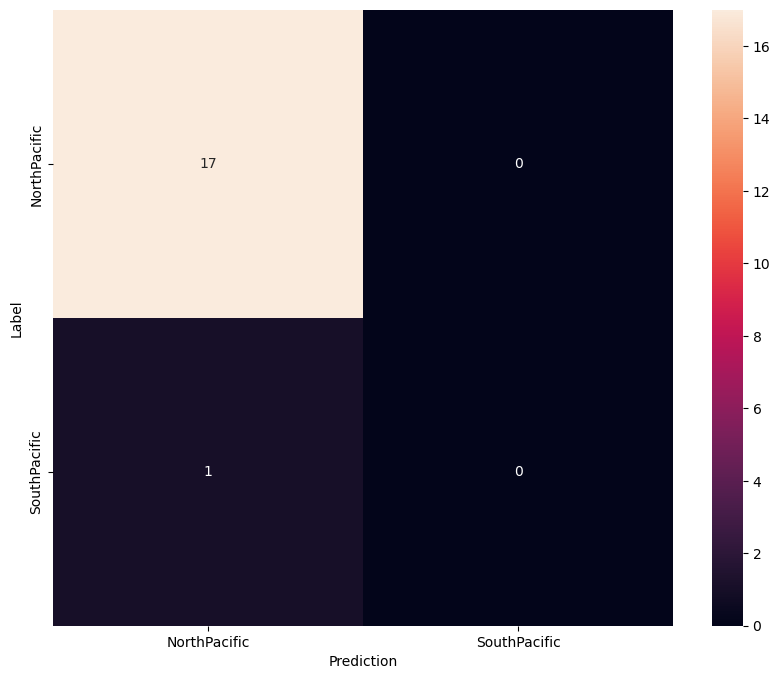

In [38]:
#confusion matrix

y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

#### Prediction

In [40]:
#label_names

In [45]:
test = data_dir/'NorthPacific/Cross_clip1.wav'
#print(test)
test = tf.io.read_file(str(test))
#print(test)
test, sample_rate = tf.audio.decode_wav(test, desired_channels=1, desired_samples=72000,)
#print(test)
test = tf.squeeze(test, axis=-1)
#print(test)
waveform = test
test = get_spectrogram(waveform)
#print(test)
test =test[tf.newaxis,...]
#print(test)

prediction = model(test)
test_labels = label_names       
plt.bar(test_labels, tf.nn.softmax(prediction[0]))
plt.title('Cross_clip1')
plt.show()

display.display(display.Audio(waveform, rate=24000))

#### Export Model

## TO DO
- optimize **images** - fade in/out, reduce noise
- optimize **spectrograms**
    - stft vs Speech Recognition 512/512/512 split
    - mel-spectrogram vs regular
- optimize **model**
    - try different types/different layers
    - softmax vs relu
    - number of epochs
    - what type of loss metric? https://www.tensorflow.org/api_docs/python/tf/keras/losses
    - callbacks?
- **Rate** - make sure 30 sec or less are covered in audio data - rate = 1,000 / 30,000.
    - **How do i choose correct rate?**